# Working with NCEO forest aboveground biomass maps

Connect to your Google Drive from Google Colab. Click on the link that will appear. Click on the copy symbol. Paste the authorisation code into the field below and click 'enter'.

In [1]:
# Load the Drive helper and mount your Google Drive as a drive in the virtual machine
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We need to install some Python libraries and import some libraries and functions from other libraries, too.

In [2]:
#import required libraries, including the sentinelsat library this time
!pip install rasterio
!pip install rasterstats
!pip install geopandas
import csv 
import geopandas as gpd
from math import floor, ceil
import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal, ogr
import os
from os import listdir
from os.path import isfile, isdir, join
import pickle
from pprint import pprint
from pyproj import Proj
from random import seed, random
import rasterio
from rasterio import plot
from rasterio.windows import Window
from rasterio.warp import Resampling
from rasterstats import zonal_stats
import sys
import zipfile
%matplotlib inline


# make sure that this path points to the location of the biomass module on Google Drive
sys.path.append('/content/drive/MyDrive/Forest Biomass')
# import our biomass module that we need in this notebook
import biomass as bm

Define your working directory. To find out what the directory path is, go to the little folder icon on the left hand pane in Colab. Find the path. Click on the three dots and select 'copy path'. Paste it into the code cell below. Check that the file names are correct and the files are in the right directory.

In [3]:
# path to your Google Drive
wd = "/content/drive/MyDrive/Forest Biomass" 
print("Connected to data directory: " + wd)

# biomass map file
biomassfile_zip = join(wd, "Kenya_biomass_map_NCEO.zip")

# Name of the shape file, source: https://data.humdata.org/dataset/ken-administrative-boundaries
shapefile_zip = join(wd, "ken_adm_iebc_20191031_shp.zip")

Connected to data directory: /content/drive/MyDrive/Forest Biomass


If the files need to be unzipped, we need to run this code cell to unzip all contents and list the contents of the target directory to check that it worked.

In [4]:
# unzip the files by calling the unzip function from the biomass library
bm.unzip(biomassfile_zip, wd)
bm.unzip(shapefile_zip, wd)

# show the contents of the working directory
print("\nList of contents of " + wd)
for f in sorted(listdir(wd)):
  print(f)


List of contents of /content/drive/MyDrive/Forest Biomass
Kenya
Kenya_biomass_map_NCEO.zip
Shapefiles.zip
__pycache__
biomass.ipynb
biomass.py
biomass_zonal_stats.csv
biomass_zonal_stats.pkl
ken_adm_iebc_20191031_shp.zip
ken_admbnda_adm0_iebc_20191031.CPG
ken_admbnda_adm0_iebc_20191031.dbf
ken_admbnda_adm0_iebc_20191031.prj
ken_admbnda_adm0_iebc_20191031.sbn
ken_admbnda_adm0_iebc_20191031.sbx
ken_admbnda_adm0_iebc_20191031.shp
ken_admbnda_adm0_iebc_20191031.shp.xml
ken_admbnda_adm0_iebc_20191031.shx
ken_admbnda_adm1_iebc_20191031.CPG
ken_admbnda_adm1_iebc_20191031.dbf
ken_admbnda_adm1_iebc_20191031.prj
ken_admbnda_adm1_iebc_20191031.sbn
ken_admbnda_adm1_iebc_20191031.sbx
ken_admbnda_adm1_iebc_20191031.shp
ken_admbnda_adm1_iebc_20191031.shp.xml
ken_admbnda_adm1_iebc_20191031.shx
ken_admbnda_adm2_iebc_20191031.CPG
ken_admbnda_adm2_iebc_20191031.cpg
ken_admbnda_adm2_iebc_20191031.dbf
ken_admbnda_adm2_iebc_20191031.prj
ken_admbnda_adm2_iebc_20191031.sbn
ken_admbnda_adm2_iebc_20191031.sbx


Define the file names of the biomass map and the admin area shapefile.

In [5]:
# choose the biomass map file from the extracted subdirectory "Kenya"
biomassfile = join(wd, "Kenya/Kenya_AGB2015_v21_sleek.tif")

# choose admin level 2 for this exercise
shapefile = join(wd, "ken_admbnda_adm2_iebc_20191031.shp")

We want to use the shapefile with the administrative boundaries for this exercise. Let us get the geographic extent of the shapefile to define our area of interest.

In [6]:
# get extent of the shapefile and its CRS using the biomass library
extent, outSpatialRef, outEPSG = bm.get_shp_extent(shapefile)
print("Extent of the shapefile:\n", extent)
print("\nCoordinate reference system (CRS) of the shapefile:\n", outSpatialRef)
print("EPSG code = ", outEPSG)

Extent of the shapefile:
 (33.910288655000045, 41.90602145900007, -4.67687988299997, 5.414123535000038)

Coordinate reference system (CRS) of the shapefile:
 GEOGCS["GCS_WGS_1984",
    DATUM["WGS_1984",
        SPHEROID["WGS_84",6378137.0,298.257223563]],
    PRIMEM["Greenwich",0.0],
    UNIT["Degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]
EPSG code =  4326


The biomass map and the shapefile are in different map projections, so we cannot directly overlay them. First, we need to reproject the biomass map to the same map projection as the shapefile.

In [7]:
# reproject the biomass map to the map projection of the shapefile
print("Reprojecting the biomass map to this projection: ", outSpatialRef)
biomassfile_warp = biomassfile.split(".")[0] + "_warped.tif" # name of the warped raster file
biomassfile_bytescaled = biomassfile_warp.split(".")[0] + "_byte.tif" # name of the output raster file

# call the GDAL Warp command for the Red and NIR bands
ds = gdal.Warp(biomassfile_warp, biomassfile, dstSRS=outSpatialRef)
ds = None #remember to close and save the output file

Reprojecting the biomass map to this projection:  GEOGCS["GCS_WGS_1984",
    DATUM["WGS_1984",
        SPHEROID["WGS_84",6378137.0,298.257223563]],
    PRIMEM["Greenwich",0.0],
    UNIT["Degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]


For displaying the biomass map on screen, we need to convert the values to unsigned integer 8-bit number format (uint8).

In [8]:
# byte scale the map
bm.bytescale(biomassfile_warp, biomassfile_bytescaled, factor=8)
print("byte scaling complete")

Creating quicklook byte-scaled image file:  /content/drive/MyDrive/Forest Biomass/Kenya/Kenya_AGB2015_v21_sleek_warped_byte.tif
byte scaling complete


Create a visualisation of the biomass map and the shapefile boundaries.

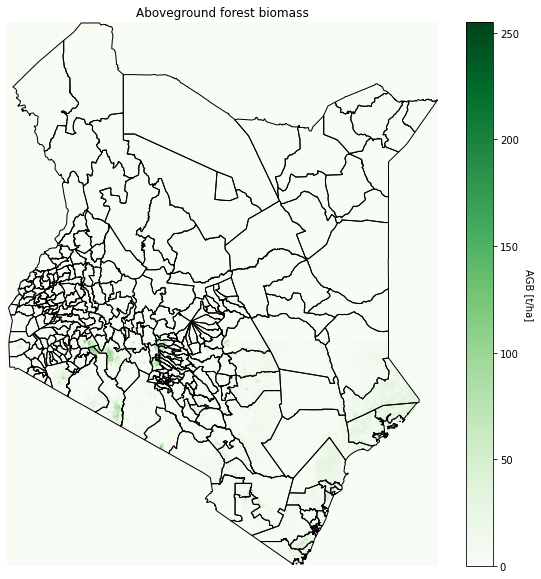

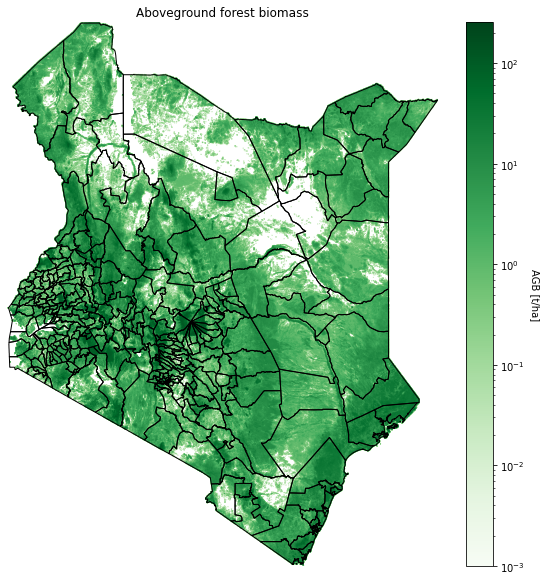

In [9]:
# define keyword arguments for Matplotlib
kwargs = {'figsize': (10,10),
         'facecolor': 'white'}


# plot the biomass map with a linear color map
fig, ax = bm.plot_map(biomassfile_bytescaled, title = "Aboveground forest biomass", 
         cmap="Greens", log=False, legend=True, legendlabel="AGB [t/ha]", **kwargs)

# plot the shapefile on the same axes object as the biomass map
gdf = gpd.read_file(shapefile)
gdf.plot(ax=ax, edgecolor='black', facecolor='none')


# plot the biomass map with a logarithmic color map
fig, ax = bm.plot_map(biomassfile_bytescaled, title = "Aboveground forest biomass", 
         cmap="Greens", log=True, legend=True, legendlabel="AGB [t/ha]", **kwargs)

# plot the shapefile on the same axes object as the biomass map
gdf = gpd.read_file(shapefile)
gdf.plot(ax=ax, edgecolor='black', facecolor='none')


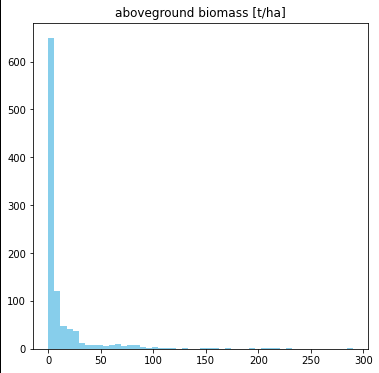

In [10]:
# define keyword arguments for our function
kwargs = {'bins': 50,
          'figsize': (6,6),
          'facecolorfig': 'white',
          'facecolorhist': 'skyblue',
          'color': 'green',
          }


# show histogram of pixel samples
fig, ax = bm.hist_sample(biomassfile_warp, n=1000, missing=65535, 
                      title="aboveground biomass [t/ha]", **kwargs)

# extract zonal statistics from the biomass map

We will use the zonal statistics function from the Rasterstats library for this purpose, as it is easy to use.

https://pythonhosted.org/rasterstats/manual.html

We will save the files in .csv format, so they can be read into Excel. We generate one file for each image.

In Python we can also save files with entire objects in their original form. The pickle library allows us to do that.

In [11]:
# define the statistics to be calculated
statsoptions = ["count", "mean", "std", "min", "max", "median"] 

# save the output statistics file in csv format suitable for Excel
statsfile = join(wd, 'biomass_zonal_stats.csv')
bm.get_zonal_stats(biomassfile_warp, shapefile, format="csv", outfile = statsfile, 
                stats = statsoptions, missing=65535)
print("Saved file: " + statsfile)

Saved file: /content/drive/MyDrive/Forest Biomass/biomass_zonal_stats.csv


In [ ]:
# save the output statistics file as a pickle file
pklfile = statsfile.split(".")[0] + ".pkl"
bm.get_zonal_stats(biomassfile_warp, shapefile, format="pkl", outfile = pklfile, 
                stats = statsoptions, missing=65535)
print("Saved file: " + pklfile)

In [ ]:
# This code cell overwrites the existing attribute table belonging to shapefile

# save the output statistics as new columns in the shapefile dbf table
bm.get_zonal_stats(biomassfile_warp, shapefile, format="dbf", outfile = shapefile, 
                stats = statsoptions, missing=65535, prefix="agb_")
print("Saved file: " + shapefile)

# Plotting data as graphs
Before we finish, let's just explore how we can make graphs to explore our results.

In [ ]:
# open the csv file with the polygon statistics for read access
f = open(statsfile,"r") 

# output the file content to the terminal
print("\nSaved statistics file: " + statsfile)

# read and print its contents (all lines)
pprint(f.read().splitlines())

# close the file
f.close()

In [ ]:
# create a figure with 1 subplot
fig, ax = plt.subplots(1, 1, figsize=(6,6))
fig.patch.set_facecolor('white')

# plot a histogram of the mean biomass per administrative area
bm.hist_dbf(shapefile, "agb_mean", ax=ax, bins = 50, missing=65535, facecolor='green', title="Biomass of Kenya")

In [ ]:
# read pickled Python object from file
s = pickle.load(open(pklfile, 'rb'))
print("\nThe pickled file looks like this:")
print(s)
print("The stored object is of type: ", type(s))
print("The list has this many elements: ", len(s))
print(type(s))
print(type(s[0]))

# get the statistics as list objects from the list of dictionaries
a_n = [b["count"] for b in s]
a_mn = [b["mean"] for b in s]
a_std = [b["std"] for b in s]
a_min = [b["min"] for b in s]
a_max = [b["max"] for b in s]
a_md = [b["median"] for b in s]

print("Original list of mean values:")
print(a_mn)
# sort the list from largest to smallest value
a_mn.sort(reverse=True)
print("Sorted list of mean values:")
print(a_mn)

# make a bar chart of the mean biomass per polygon
#plt.style.use('ggplot')
x = range(1, 1+len(s))
plt.bar(x, a_mn, color='green')
plt.xlabel("Polygon No.")
plt.ylabel("Mean aboveground forest biomass [t/ha]")
plt.title("Polygon statistics")
plt.show()

In [ ]:
# plot a map of the mean biomass per administrative area
gdf = gpd.read_file(shapefile) # read in the shapefile and its attributes
fig, ax = plt.subplots(1, 1, figsize=[10,10])
gdf.plot(column='agb_mean', ax=ax, legend=True)
fig.suptitle('Mean Forest Aboveground Biomass\n[t/ha]', fontsize=22)
ax_ax = fig.axes[0]
ax_ax.tick_params(labelsize=16) # change font size of the axes labels
bar_ax = fig.axes[1]
bar_ax.tick_params(labelsize=18) # change font size of the colour bar